In [56]:
### Install/Import Dependencies

!pip install hexalattice
import numpy as np
import matplotlib
from hexalattice.hexalattice import *

In [57]:
### Generate Grid World ans designate target

grid_size = 13
grid_rows = 13
grid_columns = 13

rewards = np.full((grid_rows, grid_columns), -1.)
rewards[6, 0] = 100

for forest in range(10):
  randRow = np.random.randint(grid_rows)
  randCol = np.random.randint(grid_columns)
  rewards[randRow, randCol] = -2

for hill in range(10):
  randRow = np.random.randint(grid_rows)
  randCol = np.random.randint(grid_columns)
  rewards[randRow, randCol] = -2

for lake in range(10):
  randRow = np.random.randint(grid_rows)
  randCol = np.random.randint(grid_columns)
  rewards[randRow, randCol] = -4
  
for mountain in range(5):
  randRow = np.random.randint(grid_rows)
  randCol = np.random.randint(grid_columns)
  rewards[randRow, randCol] = -100

def print_rewards():
  for row in rewards:
    print(row)

def print_terrain():
  for row in rewards:
    print("[",end="")
    for col in row:
      if col == -100:
        print("M", end=' ')
      elif col == -4:
        print("L", end=' ')
      elif col == -2:
        print("B", end=' ')
      elif col == -1:
        print("O", end=' ')
      elif col == 100:
        print("G", end=' ')
    print("]")

# Comment out option(s)
print_rewards()
print_terrain()


[-1. -1. -1. -1. -1. -1. -1. -1. -1. -4. -4. -4. -4.]
[  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -4.   -1.
   -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -2. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[  -1.   -1.   -1. -100.   -1.   -1.   -1.   -1. -100.   -1.   -2.   -1.
   -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -2. -1.]
[100.  -1.  -4.  -1.  -2.  -1.  -1.  -1.  -1.  -1.  -1.  -2.  -2.]
[-1. -1. -1. -1. -4. -1. -1. -2. -2. -1. -2. -1. -1.]
[-1. -1. -1. -1. -1. -2. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -2. -1. -1. -2. -1.]
[-1. -1. -1. -1. -1. -1. -1. -2. -1. -1. -2. -1. -1.]
[-4. -2. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -2.]
[-100.   -1.   -2.   -1.   -1. -100.   -4.   -1.   -1.   -1.   -1.   -2.
   -1.]
[O O O O O O O O O L L L L ]
[O O O O O O O O O M L O O ]
[O O O O O O O O O O O O O ]
[O O B O O O O O O O O O O ]
[O O O M O O O O M O B O O ]
[O O O O O O O O O O O B O ]
[G O L O B O O O O O O B B ]
[

In [58]:
# direction values:
# north: 0, northeast: 1, southeast: 2, south: 3, southwest:4 , northwest: 5
actions = ["north", "northeast", "southeast", "south", "southwest", "northwest"]
q_values = np.zeros((grid_rows, grid_columns, 6))

In [59]:
### Misc Functions

# Q-Learning Overall Algorithm:
# 1) Choose a random, non-terminal state (white square) for the agent to begin this new episode.
# 2) Choose an action for the current state. (epsilon greedy algorithm)
# 3) Perform the chosen action, and transition to the next state (i.e., move to the next location).
# 4) Receive the reward for moving to the new state, and calculate the temporal difference.
# 5) Update the Q-value for the previous state and action pair.
# 6) If the new state is a terminal state, go to #1 and start a new episode. Otherwise, go to #2.

def is_terminal(current_row_index, current_column_index):
  if rewards[current_row_index, current_column_index] > -50. and rewards[current_row_index, current_column_index] < 50:
    return False
  else:
    return True

def get_starting_location():
  current_row_index = np.random.randint(grid_rows)
  current_column_index = np.random.randint(grid_columns)
  while is_terminal(current_row_index, current_column_index):
    current_row_index = np.random.randint(grid_rows)
    current_column_index = np.random.randint(grid_columns)
  return current_row_index, current_column_index

def get_next_action(current_row_index, current_column_index, epsilon):
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else:
    return np.random.randint(6)

def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index

  if actions[action_index] == 'north' and current_column_index > 0 :
    new_column_index -= 1
  elif actions[action_index] == 'northeast' and current_column_index > 0 and current_row_index < grid_rows - 1:
    new_row_index += 1
    new_column_index -= 1
  elif actions[action_index] == 'southeast' and current_row_index < grid_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'south' and current_column_index < grid_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'southwest' and current_row_index > 0 and current_column_index < grid_columns - 1:
    new_row_index -= 1
    new_column_index += 1
  elif actions[action_index] == 'northwest' and current_row_index > 0:
    new_row_index -= 1

  return new_row_index, new_column_index

def get_shortest_path(start_row_index, start_column_index):
  if is_terminal(start_row_index, start_column_index):
    return []
  else:
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    while not is_terminal(current_row_index, current_column_index):
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    return shortest_path

In [60]:
### Training
learning_rate = 0.9 #the rate at which the AI agent should learn
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards

for episode in range(5000):
  # Step 1: choose a random non-terminal starting position
  row_index, column_index = get_starting_location()

  # Keep Going Until a terminal state
  while not is_terminal(row_index, column_index):
    # Step 2: choose an action either using q_values or random action, decided by epsilon
    action_index = get_next_action(row_index, column_index, epsilon)

    # Step 3: transition to the next state
    old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
    row_index, column_index = get_next_location(row_index, column_index, action_index)
    
    # Step 4: Receive the reward for moving to the new state, and calculate the temporal difference
    reward = rewards[row_index, column_index]
    old_q_value = q_values[old_row_index, old_column_index, action_index]
    temporal_diff = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

    # Step 5: Update Q-values
    new_q_value = old_q_value + (learning_rate * temporal_diff)
    q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Training complete!')

Training complete!


In [67]:
### Results with random starting locations

def path_to_directions(pathList):
  directions = []
  directions.append("")
  for hexIndex in range(1,len(pathList)):
    diffX = pathList[hexIndex][0] - pathList[hexIndex-1][0]
    diffY = pathList[hexIndex][1] - pathList[hexIndex-1][1]
    if diffX == 0 and diffY == -1:
      directions.append("north")
    elif diffX == 1 and diffY == -1:
      directions.append("northeast")
    elif diffX == 1 and diffY == 0:
      directions.append("southeast")
    elif diffX == 0 and diffY == 1:
      directions.append("south")
    elif diffX == -1 and diffY == 1:
      directions.append("southwest")
    elif diffX == -1 and diffY == 0:
      directions.append("northwest")
  return directions

#display a few shortest paths
for x in range(4):
  x, y = get_starting_location()
  optimal_path = get_shortest_path(x,y)
  print(optimal_path)
  print(path_to_directions(optimal_path))
  print("")

[[8, 9], [8, 8], [8, 7], [7, 7], [7, 6], [6, 6], [6, 5], [6, 4], [6, 3], [6, 2], [6, 1], [6, 0]]
['', 'north', 'north', 'northwest', 'north', 'northwest', 'north', 'north', 'north', 'north', 'north', 'north']

[[6, 2], [6, 1], [6, 0]]
['', 'north', 'north']

[[7, 0], [6, 0]]
['', 'northwest']

[[10, 11], [11, 10], [11, 9], [11, 8], [11, 7], [11, 6], [11, 5], [11, 4], [11, 3], [10, 3], [10, 2], [9, 2], [9, 1], [9, 0], [8, 0], [7, 0], [6, 0]]
['', 'northeast', 'north', 'north', 'north', 'north', 'north', 'north', 'north', 'northwest', 'north', 'northwest', 'north', 'north', 'northwest', 'northwest', 'northwest']



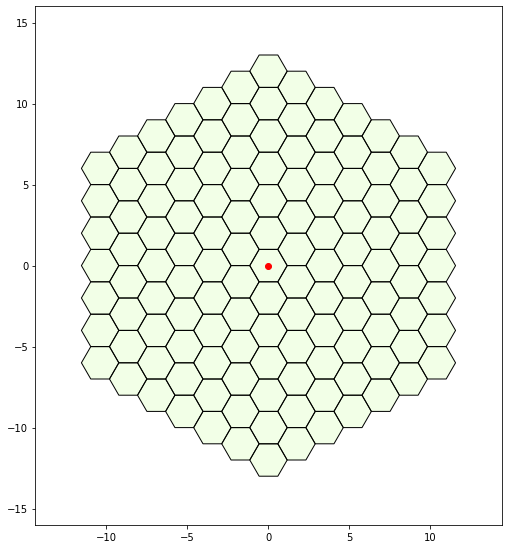

In [7]:
#hex_centers, h_ax = create_hex_grid(nx=1, ny=1, rotate_deg=30, crop_circ=12, do_plot=True, face_color=(0, 0, 0, 1), min_diam=2)
#create_hex_grid(nx=13, ny=13, rotate_deg=30, crop_circ=12, do_plot=True, face_color=(0.5, 1, 0.1, 0.1), min_diam=2, h_ax=h_ax)
create_hex_grid(nx=13, ny=13, rotate_deg=30, crop_circ=12, do_plot=True, face_color=(0.5, 1, 0.1, 0.1), min_diam=2)
#create_hex_grid(nx=grid_rows*1.5, ny=grid_columns*1.5, rotate_deg=210, do_plot=True, face_color=(0.5, 1, 0.1, 0.1))

#matplotlib.pyplot.plot(3.5, 4, "bo")
matplotlib.pyplot.plot(0, 0, "ro")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 8)